In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import traceback
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from collections import defaultdict

def plot_df(df, ax, column, label='', lower_cut=0):
    mean = df.T.groupby(df.T.index).mean().T
    std = df.T.groupby(df.T.index).std().T

    y = mean[column][lower_cut:]
    x = mean[column][lower_cut:].index
    ci = std[column][lower_cut:]
    ax.plot(x,y, label=label)
    ax.fill_between(x, (y-ci), (y+ci), alpha=.1)

def analyse_df(df, column, epoch):
    mean = df.T.groupby(df.T.index).mean().T
    std = df.T.groupby(df.T.index).std().T

    mean = mean[column].iloc[epoch]
    std = std[column].iloc[epoch]
    return mean, std


def parse_tensorboard(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])

    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    df = runlog_data.pivot(index='step', columns='metric')
    df.columns = df.columns.levels[1]
    df = df.reset_index(drop=True)
    return df


def find_checkpoints(string='', path="runs"):
    runs = []
    for root, dirs, files in os.walk(path):
        if string in root and files:
            checkpoint = [s for s in files if "events" in s]
            if not checkpoint:
                continue
            checkpoint = checkpoint[0]
            runs.append({
                'root': root,
                'checkpoint': checkpoint,
                'path': os.path.join(root, checkpoint),
            })
    return runs

In [2]:
runs = find_checkpoints(path='/home/cermavo3/projects/datasets/experiments/final/runs')
data = defaultdict(list)

for run in runs:
    df = parse_tensorboard(run['path'])
    if df.values.size > 0:
        name = run['root'].split('/')[-2][20:]
        data[name].append(df['acc'])
        data[name].append(df['acc_bal'])

dfs = {}
for k, v in data.items():
    dfs[k] = pd.DataFrame(v).T

In [4]:
results = {}
for key, data in dfs.items():
    mean, std = analyse_df(dfs[key], 'acc', epoch=-1)
    key = key.replace('_', '-')
    results[key] = f"{mean:.3f} +-{std:.3f}"

In [5]:
latex = pd.Series(results).to_latex()

In [6]:
latex

'\\begin{tabular}{ll}\n\\toprule\n{} &              0 \\\\\n\\midrule\nsample-60               &  0.570 +-0.006 \\\\\nfeatures-onehot         &  0.818 +-0.005 \\\\\nsample-80               &  0.621 +-0.018 \\\\\ntrain-only-last-lr03    &  0.446 +-0.010 \\\\\nimg-full                &  0.597 +-0.119 \\\\\naugment-none            &  0.784 +-0.007 \\\\\nsample-20               &  0.291 +-0.017 \\\\\nfeatures-model-topright &  0.474 +-0.031 \\\\\nimg-seg                 &  0.808 +-0.007 \\\\\nfeatures-model-topleft  &  0.433 +-0.034 \\\\\ntrain-full-lr03         &  0.455 +-0.057 \\\\\nfeatures-model-right    &  0.643 +-0.008 \\\\\nfeatures-model-left     &  0.646 +-0.074 \\\\\nbaseline                &  0.812 +-0.014 \\\\\ntrain-only-last-lr04    &  0.423 +-0.007 \\\\\nsample-40               &  0.453 +-0.023 \\\\\ntrain-pretrain-lr04     &  0.704 +-0.008 \\\\\naugment-randaug         &  0.841 +-0.009 \\\\\nfeatures-model-top      &  0.347 +-0.019 \\\\\ntrain-pretrain-lr03     &  0.825 +-0

### Full vs Segmentation vs Bounding box

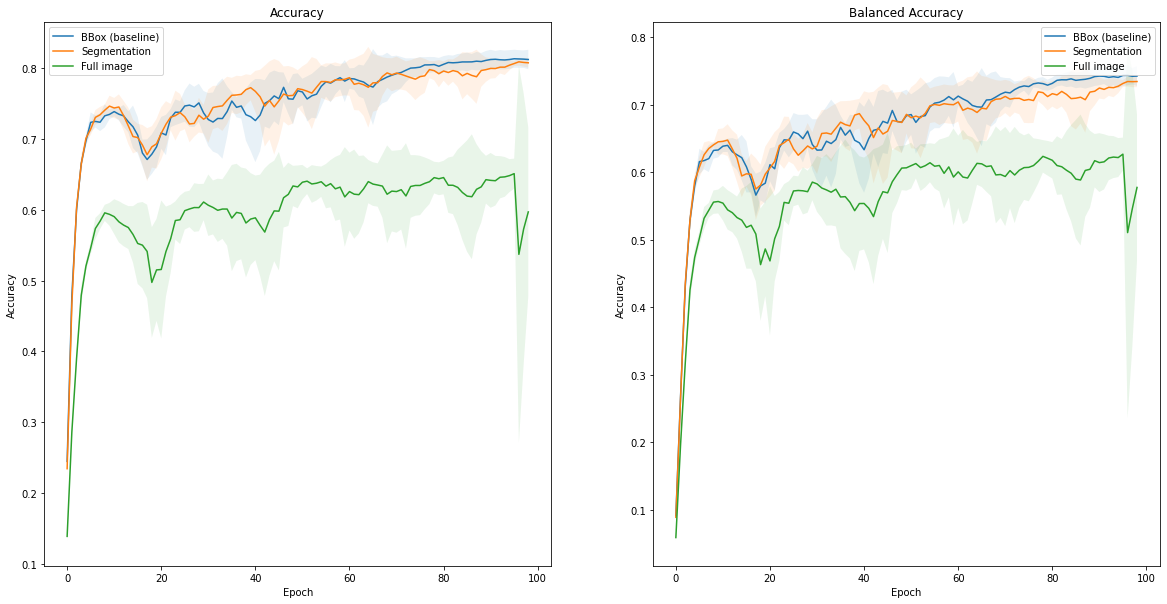

In [3]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

plot_df(dfs['baseline'], ax1, label='BBox (baseline)', column='acc')
plot_df(dfs['baseline'], ax2, label='BBox (baseline)', column='acc_bal')

plot_df(dfs['img_seg'], ax1, label='Segmentation', column='acc')
plot_df(dfs['img_seg'], ax2, label='Segmentation', column='acc_bal')

plot_df(dfs['img_full'], ax1, label='Full image', column='acc')
plot_df(dfs['img_full'], ax2, label='Full image', column='acc_bal')

ax1.title.set_text('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')

ax2.title.set_text('Balanced Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='best')


### Augmentations
- Augmentation significantly helps stabilise training.
- Basic augmentations: rotation, flips, random jitter.

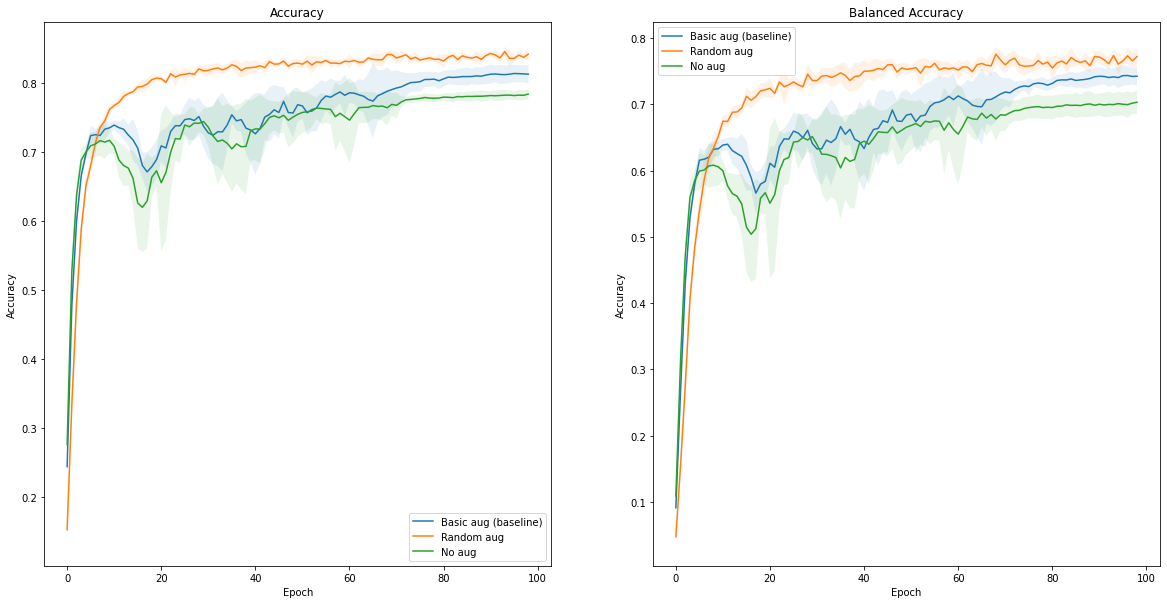

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

plot_df(dfs['baseline'], ax1, label='Basic aug (baseline)', column='acc')
plot_df(dfs['baseline'], ax2, label='Basic aug (baseline)', column='acc_bal')

plot_df(dfs['augment_randaug'], ax1, label='Random aug', column='acc')
plot_df(dfs['augment_randaug'], ax2, label='Random aug', column='acc_bal')

plot_df(dfs['augment_none'], ax1, label='No aug', column='acc')
plot_df(dfs['augment_none'], ax2, label='No aug', column='acc_bal')

ax1.title.set_text('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')

ax2.title.set_text('Balanced Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='best')


### Pretrain vs fully trained

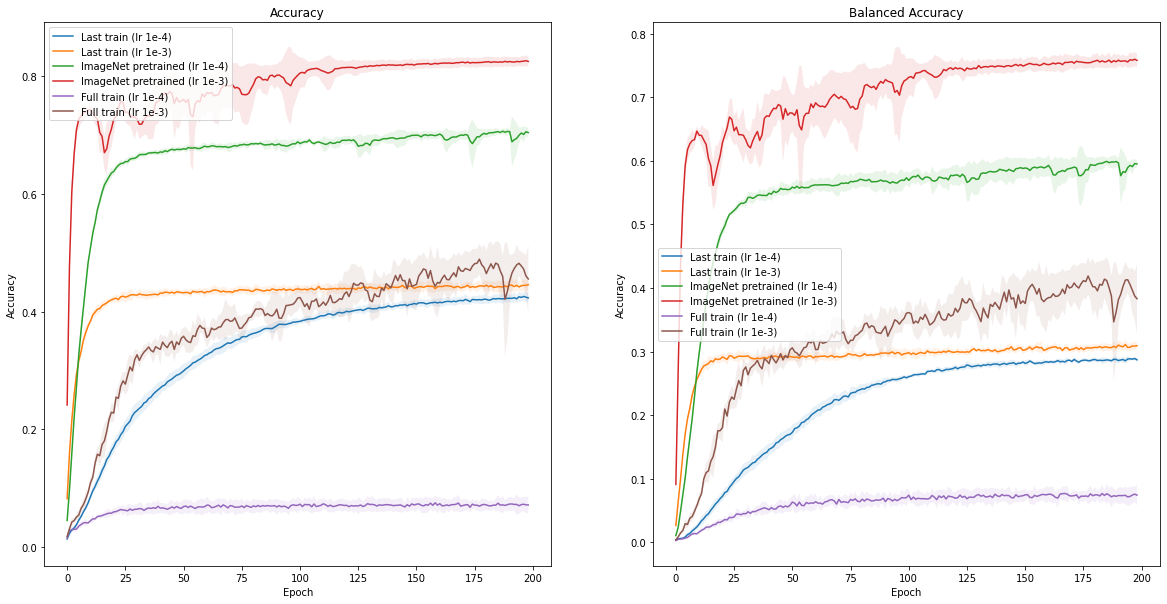

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

plot_df(dfs['train_only_last-lr04'], ax1, label='Last train (lr 1e-4)', column='acc')
plot_df(dfs['train_only_last-lr04'], ax2, label='Last train (lr 1e-4)', column='acc_bal')
plot_df(dfs['train_only_last_lr03'], ax1, label='Last train (lr 1e-3)', column='acc')
plot_df(dfs['train_only_last_lr03'], ax2, label='Last train (lr 1e-3)', column='acc_bal')

plot_df(dfs['train_pretrain_lr04'], ax1, label='ImageNet pretrained (lr 1e-4)', column='acc')
plot_df(dfs['train_pretrain_lr04'], ax2, label='ImageNet pretrained (lr 1e-4)', column='acc_bal')
plot_df(dfs['train_pretrain_lr03'], ax1, label='ImageNet pretrained (lr 1e-3)', column='acc')
plot_df(dfs['train_pretrain_lr03'], ax2, label='ImageNet pretrained (lr 1e-3)', column='acc_bal')

plot_df(dfs['train_full_lr04'], ax1, label='Full train (lr 1e-4)', column='acc')
plot_df(dfs['train_full_lr04'], ax2, label='Full train (lr 1e-4)', column='acc_bal')
plot_df(dfs['train_full_lr03'], ax1, label='Full train (lr 1e-3)', column='acc')
plot_df(dfs['train_full_lr03'], ax2, label='Full train (lr 1e-3)', column='acc_bal')

ax1.title.set_text('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')

ax2.title.set_text('Balanced Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='best')


### Categorical features

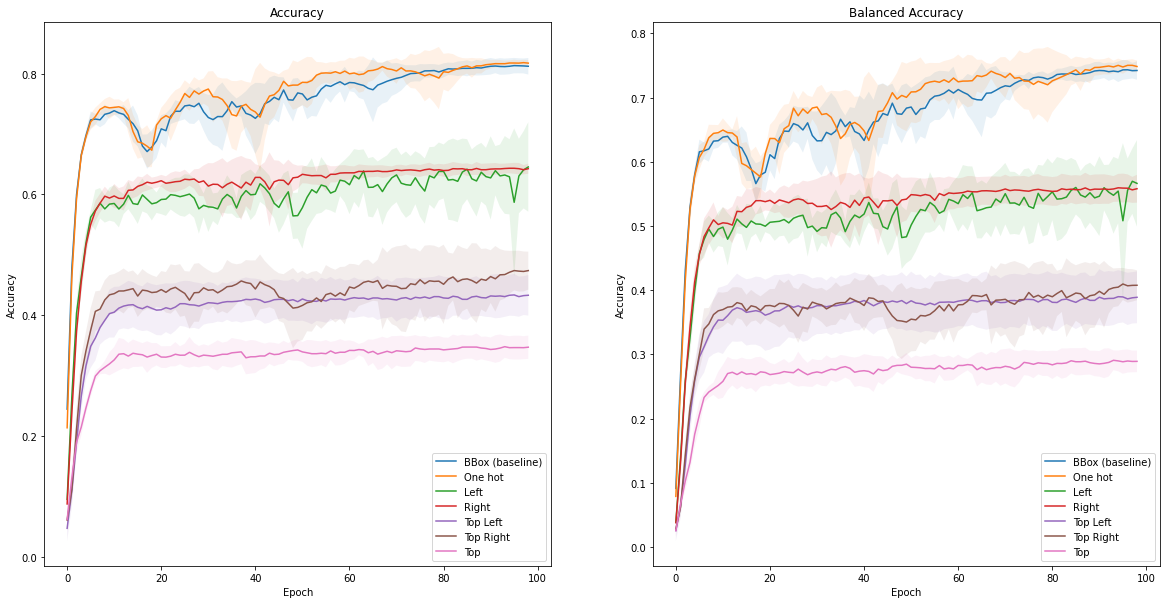

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

plot_df(dfs['baseline'], ax1, label='BBox (baseline)', column='acc')
plot_df(dfs['baseline'], ax2, label='BBox (baseline)', column='acc_bal')

plot_df(dfs['features_onehot'], ax1, label='One hot', column='acc')
plot_df(dfs['features_onehot'], ax2, label='One hot', column='acc_bal')


plot_df(dfs['features_model_left'], ax1, label='Left', column='acc')
plot_df(dfs['features_model_left'], ax2, label='Left', column='acc_bal')

plot_df(dfs['features_model_right'], ax1, label='Right', column='acc')
plot_df(dfs['features_model_right'], ax2, label='Right', column='acc_bal')

plot_df(dfs['features_model_topleft'], ax1, label='Top Left', column='acc')
plot_df(dfs['features_model_topleft'], ax2, label='Top Left', column='acc_bal')

plot_df(dfs['features_model_topright'], ax1, label='Top Right', column='acc')
plot_df(dfs['features_model_topright'], ax2, label='Top Right', column='acc_bal')

plot_df(dfs['features_model_top'], ax1, label='Top', column='acc')
plot_df(dfs['features_model_top'], ax2, label='Top', column='acc_bal')


ax1.title.set_text('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')

ax2.title.set_text('Balanced Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='best')


### Composite model

In [15]:
path = "/home/cermavo3/projects/datasets/experiments/final/configs/features_model_left.py"

In [27]:
from collections import defaultdict
lenght = []
for split in splits:
    lenght.append({
        'train': len(split['train']),
        'valid': len(split['valid']),
    })

In [44]:
from tqdm import tqdm
import pandas as pd
import os
import sys
sys.path.append(os.path.join('../..'))
from wildlife_training.inference import predict_classifier

100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


0.6402753872633391


100%|██████████| 9/9 [00:23<00:00,  2.58s/it]


0.6383363471971067


100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


0.657439446366782


100%|██████████| 10/10 [00:24<00:00,  2.45s/it]


0.6418685121107266


100%|██████████| 10/10 [00:25<00:00,  2.58s/it]

0.6372712146422629


In [60]:
dfs['features_model_left']

,acc,acc_bal,acc,acc_bal,acc,acc_bal,acc,acc_bal,acc,acc_bal
0,0.066092,0.030923,0.088722,0.034572,0.098160,0.040262,0.117647,0.045629,0.104322,0.041998
1,0.239943,0.114129,0.293233,0.157931,0.260736,0.129709,0.288084,0.155839,0.239940,0.139933
2,0.409483,0.251575,0.415038,0.273353,0.403374,0.251396,0.417798,0.279929,0.372578,0.241152
3,0.484195,0.319169,0.497744,0.370743,0.466258,0.328556,0.447964,0.308809,0.420268,0.300089
4,0.505747,0.374142,0.527820,0.414716,0.519939,0.402512,0.547511,0.430210,0.496274,0.372669
...,...,...,...,...,...,...,...,...,...,...
94,0.692529,0.611480,0.607519,0.518149,0.674847,0.587953,0.636501,0.564897,0.535022,0.489445
95,0.691092,0.610702,0.625564,0.545489,0.679448,0.587339,0.393665,0.308615,0.545455,0.488568
96,0.691092,0.611573,0.609023,0.533686,0.680982,0.592120,0.633484,0.555091,0.538003,0.485607
97,0.689655,0.609405,0.631579,0.564403,0.679448,0.589906,0.669683,0.600662,0.533532,0.484022


### Dataset size

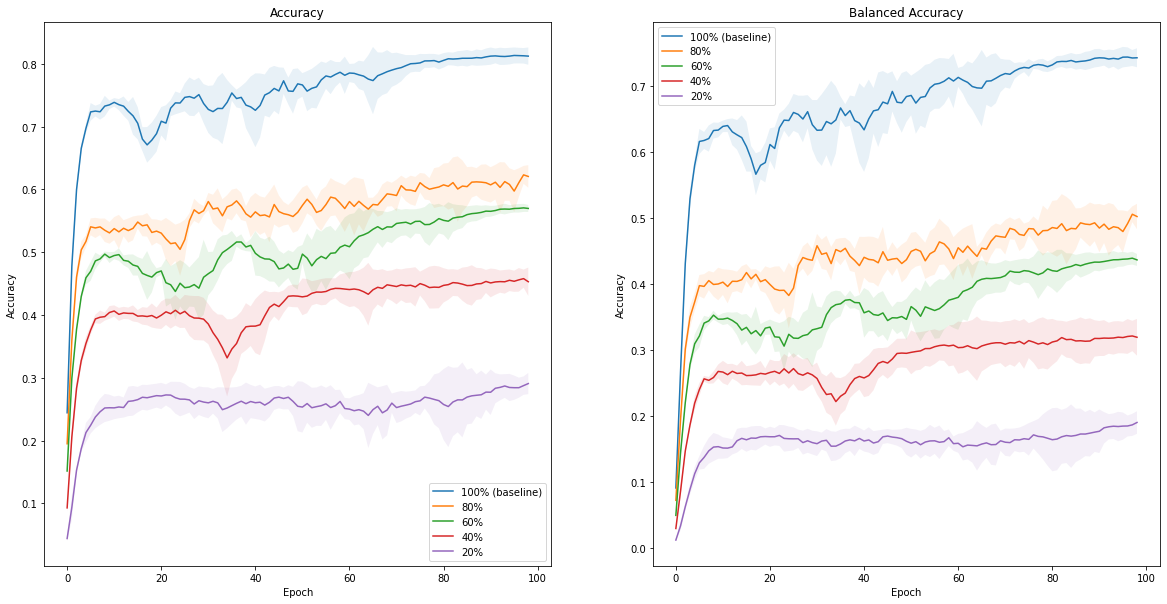

In [12]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

plot_df(dfs['baseline'], ax1, label='100% (baseline)', column='acc')
plot_df(dfs['baseline'], ax2, label='100% (baseline)', column='acc_bal')

plot_df(dfs['sample_80'], ax1, label='80%', column='acc')
plot_df(dfs['sample_80'], ax2, label='80%', column='acc_bal')


plot_df(dfs['sample_60'], ax1, label='60%', column='acc')
plot_df(dfs['sample_60'], ax2, label='60%', column='acc_bal')

plot_df(dfs['sample_40'], ax1, label='40%', column='acc')
plot_df(dfs['sample_40'], ax2, label='40%', column='acc_bal')

plot_df(dfs['sample_20'], ax1, label='20%', column='acc')
plot_df(dfs['sample_20'], ax2, label='20%', column='acc_bal')


ax1.title.set_text('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')

ax2.title.set_text('Balanced Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='best')
